In [1]:
!apt-get install -y fonts-nanum  # 나눔 폰트를 설치
!fc-cache -fv  # 폰트 캐시를 갱신
!rm ~/.cache/matplotlib -rf  # matplotlib의 캐시를 삭제

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.stattools import grangercausalitytests

# 전처리

In [6]:
#### target ####
################

# 출생아
y = pd.read_csv('/content/drive/MyDrive/KUBIG/hackathon/가공데이터/한국출생아.csv',index_col='시점',parse_dates=['시점'])

## 학령인구
edu = pd.read_csv('/content/drive/MyDrive/KUBIG/hackathon/가공데이터/학령인구.csv',index_col='Unnamed: 0',parse_dates=['Unnamed: 0'])
edu.index = pd.to_datetime(edu.index)
# 초등학교
edu_elem = edu.iloc[:,0]
# 중학교
edu_mid = edu.iloc[:,1]
# 고등학교
edu_high = edu.iloc[:,2]
# 대학교
edu_univ = edu.iloc[:,3]

In [7]:
#### 경제파트 ####
##################

## gni
gni = pd.read_csv('/content/drive/MyDrive/KUBIG/hackathon/가공데이터/1인당_실질_국민_총소득.csv의 사본', index_col='시점', parse_dates=['시점'])
gni.rename(columns={"1인당 실질 국민총소득(만 원)":"GNI","전년 대비 증가율(%)":"GNI 증감률"},inplace=True)
# 1 gni
gni_real = gni[['GNI']]
# 2 gni 증가율
gni_rate = gni[['GNI 증감률']]

## 사교육비
tutor_expense = pd.read_csv('/content/drive/MyDrive/KUBIG/hackathon/가공데이터/학생_1인당_연평균_사교육비.csv의 사본',index_col='시점',parse_dates=['시점'])
tutor_expense.rename(columns={'전체(만 원)':'전체_사교육비',	'초등학교(만 원)':'초등학교_사교육비',	'중학교(만 원)':'중학교_사교육비',	'고등학교(만 원)':'고등학교_사교육비'}, inplace=True)
# 3 전체 사교육비
tutor_tot = tutor_expense[['전체_사교육비']]
# 4 초등학교 사교육비
tutor_elem = tutor_expense[['초등학교_사교육비']]
# 5 중학교 사교육비
tutor_mid = tutor_expense[['중학교_사교육비']]
# 6 고등학교 사교육비
tutor_high = tutor_expense[['고등학교_사교육비']]

# 7 gdp 디플레이터 증감률
gdp_rate = pd.read_csv('/content/drive/MyDrive/KUBIG/hackathon/가공데이터/GDP_디플레이터(2010년기준)_증감률.csv의 사본의 사본',index_col='시점',parse_dates=['시점'])
gdp_rate.rename(columns={"GDP_디플레이터(2010)_증감률(%)":"GDP디플레이터_증감률"}, inplace=True)

## 소비자물가지수 증감률
cpi_annual_rate = pd.read_csv('/content/drive/MyDrive/KUBIG/hackathon/가공데이터/소비자물가지수_연간등략률.csv의 사본',index_col='시점',parse_dates=['시점'])
cpi_annual_rate.rename(columns={'총지수_연간등략률(%)':'총지수_증감률', '생활물가지수_연간등략률(%)':'생활물가지수_증감률', '신선식품지수_연간등략률(%)':'신선식품지수_증감률'}, inplace=True)
# 8 총지수 증감률
cpi_tot = cpi_annual_rate.iloc[:,0]
# 9 생활물가지수 증감률
cpi_daily = cpi_annual_rate.iloc[:,1]
# 10 신선식품지수 증감률
cpi_fresh = cpi_annual_rate.iloc[:,2]

##################
##################

#### 사회파트 ####
##################

## 조혼인율&조이혼율
marry = pd.read_csv("/content/drive/MyDrive/KUBIG/hackathon/가공데이터/조혼인율 및 조이혼율.csv", index_col='시점',parse_dates=['시점'])
marry.rename(columns={"조혼인율 (천명당)":"조혼인율",	"조이혼율 (천명당)":"조이혼율"}, inplace=True)
# 11 조혼인율
marriage = marry[['조혼인율']]
# 12 조이혼율
divorce = marry[['조이혼율']]

# 13 평균여성 초혼연령
mar_age = pd.read_csv("/content/drive/MyDrive/KUBIG/hackathon/가공데이터/평균 여성 초혼 연령.csv", index_col='Unnamed: 0',parse_dates=['Unnamed: 0'])
mar_age.index = pd.to_datetime(mar_age.index)
mar_age.rename(columns={"평균 여성 초혼 연령(세)":"여성초혼 연령"}, inplace=True)

# 14 국공립 어린이집 비율
kinder = pd.read_csv("/content/drive/MyDrive/KUBIG/hackathon/가공데이터/국공립 어린이집 비율.csv", index_col='시점',parse_dates=['시점'])
kin_ratio = kinder[["국공립 어린이집 비율(%)"]]
kin_ratio.rename(columns={'국공립 어린이집 비율(%)':"국공립 어린이집 비율"}, inplace=True)
# 15 여성경제 활동참가율
female = pd.read_csv("/content/drive/MyDrive/KUBIG/hackathon/가공데이터/여성경제 활동참가율.csv", index_col='Unnamed: 0',parse_dates=['Unnamed: 0'])
female.index = pd.to_datetime(female.index)

## 인구밀도
density = pd.read_csv("/content/drive/MyDrive/KUBIG/hackathon/가공데이터/인구밀도.csv", index_col='Unnamed: 0',parse_dates=['Unnamed: 0'])
density.index = pd.to_datetime(density.index)
density.rename(columns={'수도권':'수도권_인구밀도','부산':'부산_인구밀도'}, inplace=True)
# 16 수도권 인구밀도
den_cap = density[['수도권_인구밀도']]
# 17 부산 인구밀도
den_bus = density[['부산_인구밀도']]

##################
##################

In [8]:
lst = [gni,tutor_expense,gdp_rate,cpi_annual_rate,marry,mar_age,kin_ratio,female,density,y,edu]
df = pd.concat(lst, axis=1).loc[:'2022-01-01']
df.tail()

,GNI,GNI 증감률,전체_사교육비,초등학교_사교육비,중학교_사교육비,고등학교_사교육비,GDP디플레이터_증감률,총지수_증감률,생활물가지수_증감률,신선식품지수_증감률,...,여성초혼 연령,국공립 어린이집 비율,여성경제 활동참가율,수도권_인구밀도,부산_인구밀도,출생아수,초등학교,중학교,고등학교,대학교
2018-01-01,3532.0,1.1,29.1,26.3,31.2,32.1,0.5,1.5,1.6,3.6,...,30.40,9.195578,52.9,2164.0,4420.0,326800.0,2756000,1340000,1574000,2593000
2019-01-01,3532.0,0.0,32.1,29.0,33.8,36.5,-0.8,0.4,0.2,-5.1,...,30.59,11.570469,53.5,2179.0,4391.0,302700.0,2766000,1319000,1453000,2537000
2020-01-01,3530.0,-0.1,30.2,23.5,34.2,39.6,1.6,0.5,0.4,9.0,...,30.78,13.006336,52.8,2193.0,4358.0,272300.0,2724000,1364000,1390000,2410000
2021-01-01,3659.0,3.7,36.7,32.8,39.2,41.9,2.8,2.5,3.2,6.2,...,31.08,16.353847,53.3,2195.0,4320.0,260600.0,2718000,1379000,1344000,2258000
2022-01-01,3642.0,-0.5,41.0,37.2,43.8,46.0,1.3,5.1,6.0,5.4,...,31.26,18.759499,54.6,2195.0,4278.0,249100.0,2701000,1366000,1322000,2093000


In [9]:
len(['GNI', 'GNI 증감률', '전체_사교육비', '초등학교_사교육비', '중학교_사교육비', '고등학교_사교육비', 'GDP디플레이터_증감률', '총지수_증감률', '생활물가지수_증감률', '신선식품지수_증감률', '조혼인율', '조이혼율', '여성초혼 연령', '국공립 어린이집 비율', '여성경제 활동참가율', '수도권_인구밀도', '부산_인구밀도'])

17

In [10]:
# df.to_csv("/content/drive/MyDrive/KUBIG/hackathon/가공데이터/학령인구예측.csv")

# 정상성 검정

In [11]:
# 예시 데이터 (실제 데이터로 대체해야 함)
data = [y,gni_real,gni_rate,tutor_tot,tutor_elem,tutor_mid,tutor_high,gdp_rate,cpi_tot,cpi_daily,cpi_fresh,marriage,divorce,mar_age,kin_ratio,female,den_cap,den_bus]
name = ['출생아수']
name.extend(list(df.columns[:-5]))

stat_data = []
stat_name = []
# non-stationary
nstat_data = []
nstat_name = []
diff1_data = []
diff1_name = []
diff2_data = []
diff2_name = []

# print(len(data),len(name))

for index,var in enumerate(data):
# ADF 검정 수행
    result = kpss(var)
    adf_statistic = result[0]
    p_value = result[1]

    # print(f'ADF 통계량: {adf_statistic}')
    # print(f'p-value: {p_value}')

    if p_value <= 0.05:
        print(f'KPSS 검정결과 {name[index]} 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.')

        # log = np.log1p(var)
        # log_first = pd.Series(var).diff().dropna()
        log_first = np.log1p(var).diff().dropna()

        result = kpss(log_first)
        adf_statistic = result[0]
        p_value = result[1]

        # print(f'>> ADF 통계량: {adf_statistic}')
        # print(f'>> p-value: {p_value}')

        if p_value <= 0.05:
            print(f'>> KPSS 검정결과 1차분한 {name[index]} 시계열 데이터가 정상성을 가지지 않습니다.')

            log_second = np.log1p(var).diff().diff().dropna()

            result = kpss(log_second)
            adf_statistic = result[0]
            p_value = result[1]

            # print(f'>>>> ADF 통계량: {adf_statistic}')
            # print(f'>>>> p-value: {p_value}')

            if p_value <=0.05:
                print(f'>>>> KPSS 검정결과 2차분한 {name[index]} 시계열 데이터가 정상성을 가지지 않습니다.')
                nstat_data.append(var)
                nstat_name.append(name[index])

            else:
                print(f'>>>> KPSS 검정결과 2차분한 {name[index]} 시계열 데이터가 정상성을 가집니다.')
                diff2_data.append(var)
                diff2_name.append(name[index])

        else:
            print(f'>>>> KPSS 검정결과 1차분한 {name[index]} 시계열 데이터가 정상성을 가집니다.')
            diff1_data.append(var)
            diff1_name.append(name[index])

    else:
        print(f'ADF 검정결과 {name[index]} 시계열 데이터가 정상성을 가집니다.')
        stat_data.append(var)
        stat_name.append(name[index])


    print()

print("정상성 :", stat_name)
print("1차분결과 정상성: ", diff1_name)
print("2차분결과 정상성: ", diff2_name)
print('정상성 안띰 :', nstat_name)

KPSS 검정결과 출생아수 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 출생아수 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 GNI 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>> KPSS 검정결과 1차분한 GNI 시계열 데이터가 정상성을 가지지 않습니다.
>>>> KPSS 검정결과 2차분한 GNI 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 GNI 증감률 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 GNI 증감률 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 전체_사교육비 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 전체_사교육비 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 초등학교_사교육비 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 초등학교_사교육비 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 중학교_사교육비 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>>>> KPSS 검정결과 1차분한 중학교_사교육비 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 고등학교_사교육비 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>> KPSS 검정결과 1차분한 고등학교_사교육비 시계열 데이터가 정상성을 가지지 않습니다.
>>>> KPSS 검정결과 2차분한 고등학교_사교육비 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 GDP디플레이터_증감률 시계열 데이터가 정상성을 가지지 않으므로 차분을 계산합니다.
>> KPSS 검정결과 1차분한 GDP디플레이터_증감률 시계열 데이터가 정상성을 가지지 않습니다.
>>>> KPSS 검정결과 2차분한 GDP디플레이터_증감률 시계열 데이터가 정상성을 가집니다.

KPSS 검정결과 총지수_증감률 시계열 데이터가 정상성을 가

# 인과성 검정

정상성 띄는 factor

In [21]:
max_lag = 8

# [gni_real,gni_rate,tutor_tot,tutor_elem,tutor_mid,tutor_high,gdp_rate,cpi_tot,cpi_daily,cpi_fresh,marriage,divorce,mar_age,kin_ratio,female,den_cap,den_bus]

stat_data = [cpi_fresh, divorce, kin_ratio]
stat_name = ['신선식품지수_증감률', '조이혼율', '국공립 어린이집 비율']

print('정상성을 띄는 factor 개수 : ',len(stat_data))#, len(stat_name))

for j in range(len(stat_data)):
    test = pd.concat([stat_data[j],np.log1p(y).diff()], axis=1).dropna()
    print(stat_name[j])
    try:
      result = grangercausalitytests(test,maxlag= max_lag,verbose=False) # lag 8
      for i in range(1,max_lag+1):
          # ssr F test & chi2 test , likelihood ratio test , parameter F test => 4개중 3개이상 유의수준보다 작으면 인과관계 있다고 판단.
          if sum([result[i][0]['ssr_ftest'][1]<0.05, result[i][0]['ssr_chi2test'][1]<0.05]) >=1 :
              print(f'{i}번째 lag는 인과성이 있다.')
    except: pass
    print()

정상성을 띄는 factor 개수 :  3
신선식품지수_증감률
8번째 lag는 인과성이 있다.

조이혼율
7번째 lag는 인과성이 있다.
8번째 lag는 인과성이 있다.

국공립 어린이집 비율
7번째 lag는 인과성이 있다.
8번째 lag는 인과성이 있다.



log >> 1차분 결과 정상성 띄는 factor

In [22]:
max_lag = 8

[gni_real,gni_rate,tutor_tot,tutor_elem,tutor_mid,tutor_high,gdp_rate,cpi_tot,cpi_daily,cpi_fresh,marriage,divorce,mar_age,kin_ratio,female,den_cap,den_bus]

diff1_data = [gni_rate,tutor_tot,tutor_elem,tutor_mid,cpi_tot,marriage,mar_age,female,den_bus]
diff1_name = ['GNI 증감률', '전체_사교육비', '초등학교_사교육비', '중학교_사교육비', '총지수_증감률', '조혼인율', '여성초혼 연령', '여성경제 활동참가율', '부산_인구밀도']

print('1차분 후 정상성을 띄는 factor 개수 : ',len(diff1_data))#, len(diff1_name))

for j in range(len(diff1_data)):
    test = pd.concat([diff1_data[j].diff(),np.log1p(y).diff()], axis=1).dropna()
    print(diff1_name[j])
    try:
      result = grangercausalitytests(test,maxlag= max_lag,verbose=False) # lag 8
      for i in range(1,max_lag+1):
          # ssr F test & chi2 test , likelihood ratio test , parameter F test => 4개중 3개이상 유의수준보다 작으면 인과관계 있다고 판단.
          if sum([result[i][0]['ssr_ftest'][1]<0.05, result[i][0]['ssr_chi2test'][1]<0.05]) >=1 :
              print(f'{i}번째 lag는 인과성이 있다.')
    except: pass
    print()

1차분 후 정상성을 띄는 factor 개수 :  9
GNI 증감률
1번째 lag는 인과성이 있다.
4번째 lag는 인과성이 있다.
5번째 lag는 인과성이 있다.
6번째 lag는 인과성이 있다.

전체_사교육비

초등학교_사교육비

중학교_사교육비

총지수_증감률
5번째 lag는 인과성이 있다.
6번째 lag는 인과성이 있다.
7번째 lag는 인과성이 있다.
8번째 lag는 인과성이 있다.

조혼인율
7번째 lag는 인과성이 있다.
8번째 lag는 인과성이 있다.

여성초혼 연령
7번째 lag는 인과성이 있다.
8번째 lag는 인과성이 있다.

여성경제 활동참가율
7번째 lag는 인과성이 있다.
8번째 lag는 인과성이 있다.

부산_인구밀도



log >> 2 차분 결과 정상성 띄는 factor

In [24]:
max_lag = 8

[gni_real,gni_rate,tutor_tot,tutor_elem,tutor_mid,tutor_high,gdp_rate,cpi_tot,cpi_daily,cpi_fresh,marriage,divorce,mar_age,kin_ratio,female,den_cap,den_bus]

diff2_data = [gni_real,tutor_high,gdp_rate,cpi_daily,den_cap]
diff2_name = ['GNI', '고등학교_사교육비', 'GDP디플레이터_증감률', '생활물가지수_증감률', '수도권_인구밀도']

print('2차분 후 정상성을 띄는 factor 개수 : ',len(diff2_data))#, len(diff2_name))

for j in range(len(diff2_data)):
    test = pd.concat([diff2_data[j].diff().diff(),np.log1p(y).diff()], axis=1).dropna()
    print(diff2_name[j])
    try:
      result = grangercausalitytests(test,maxlag= max_lag,verbose=False) # lag 8
      for i in range(1,max_lag+1):
          # ssr F test & chi2 test , likelihood ratio test , parameter F test => 4개중 3개이상 유의수준보다 작으면 인과관계 있다고 판단.
          if sum([result[i][0]['ssr_ftest'][1]<0.05, result[i][0]['ssr_chi2test'][1]<0.05]) >=1 :
              print(f'{i}번째 lag는 인과성이 있다.')
    except: pass
    print()

2차분 후 정상성을 띄는 factor 개수 :  5
GNI

고등학교_사교육비

GDP디플레이터_증감률
6번째 lag는 인과성이 있다.
7번째 lag는 인과성이 있다.
8번째 lag는 인과성이 있다.

생활물가지수_증감률

수도권_인구밀도



# lag 추출

인과성이 있는 데이터 분석

In [15]:
[gni_real,gni_rate,tutor_tot,tutor_elem,tutor_mid,tutor_high,gdp_rate,cpi_tot,cpi_daily,cpi_fresh,marriage,divorce,mar_age,kin_ratio,female,den_cap,den_bus]

select_data = [gdp_rate,cpi_tot,gni_rate,marriage,divorce,female,marriage,mar_age,kin_ratio]
select_name = ["GDP디플레이터 증감률","총지수 증감률","신선식품지수 증감률","GNI 증감률","조혼인율","조이혼율","여성경제 활동참가율","여성초혼 연령","국공립 어린이집 비율"]
len(select_data), len(select_name)

(9, 9)

In [16]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation.
    Shifted data filled with NaNs

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    wrap : NaN 채우는 것. shift 하면서 사라진 값으로 다시 채우기. 값이 순환되게 된다. wrap=False 이면 NaN은 drop하고 correlation 구한다.
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

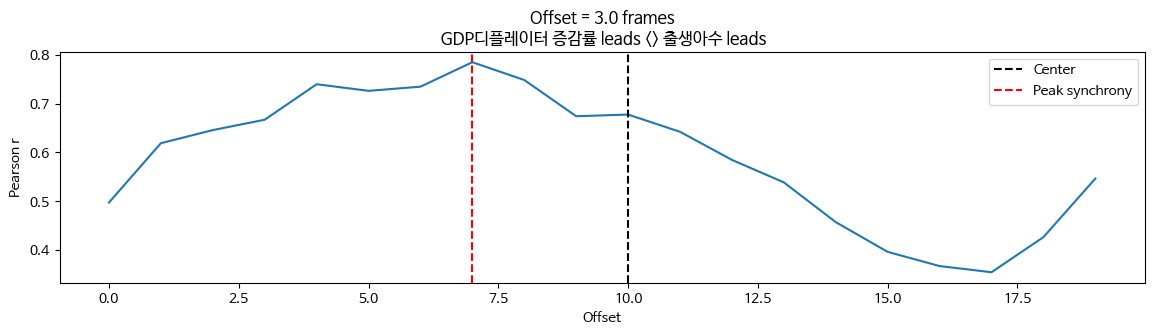

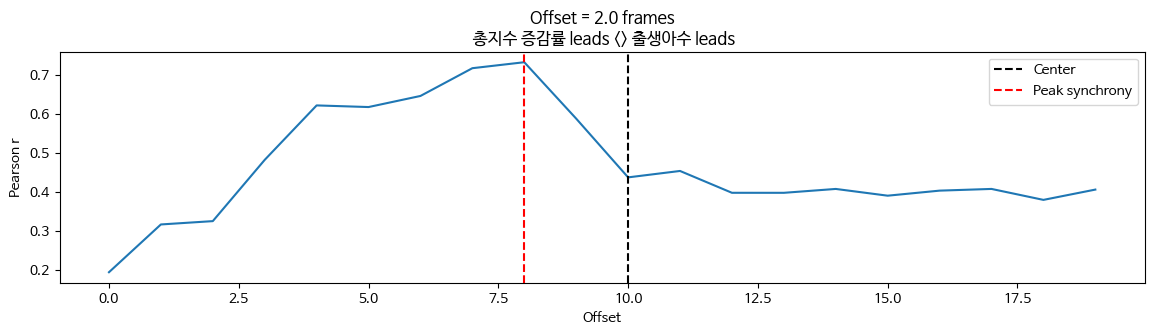

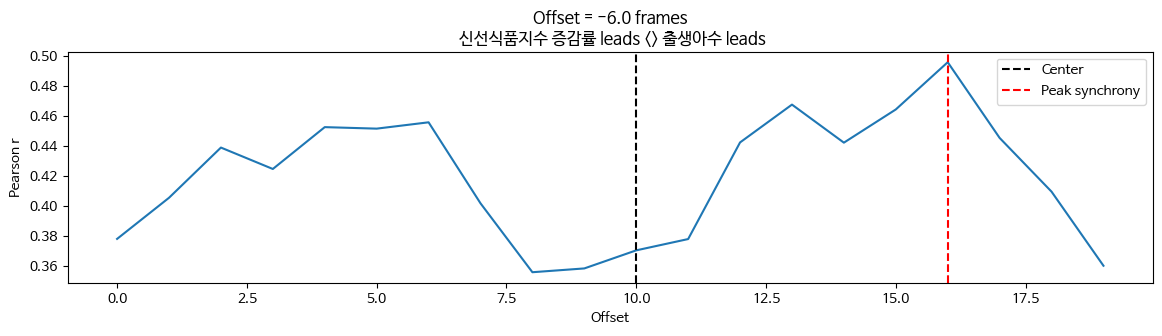

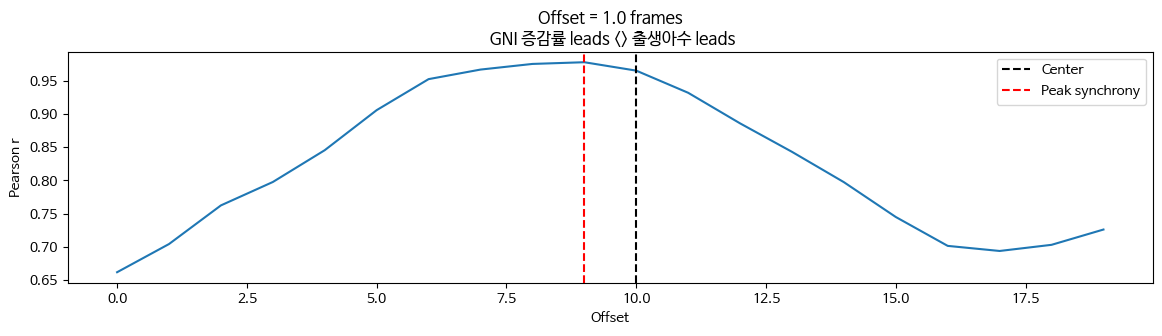

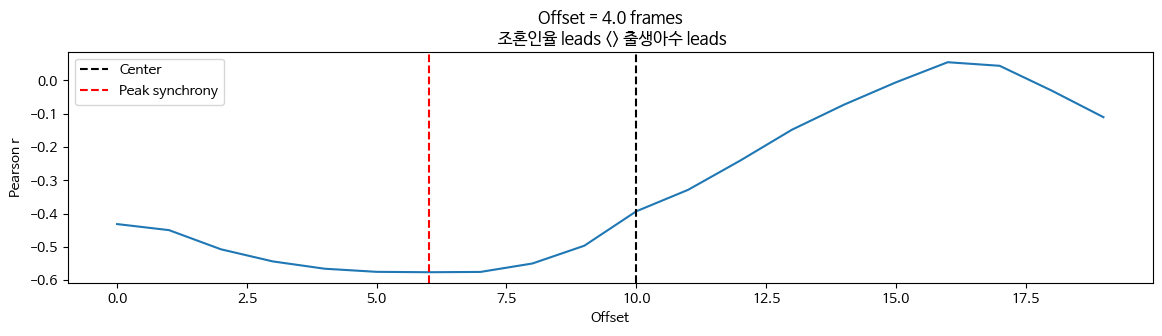

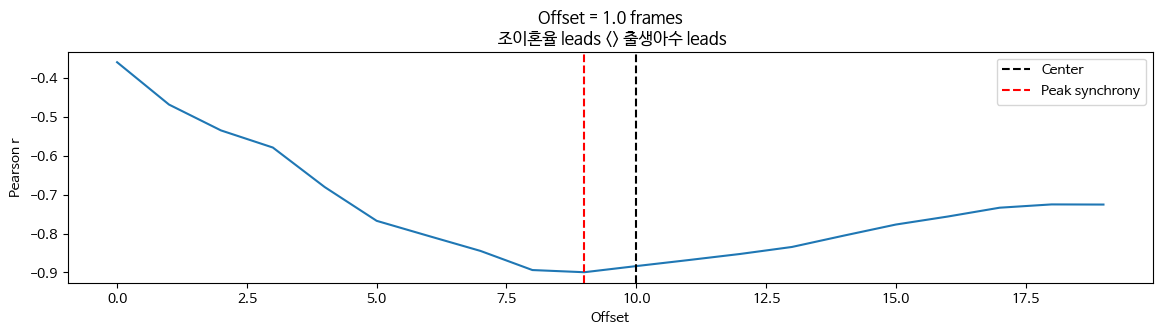

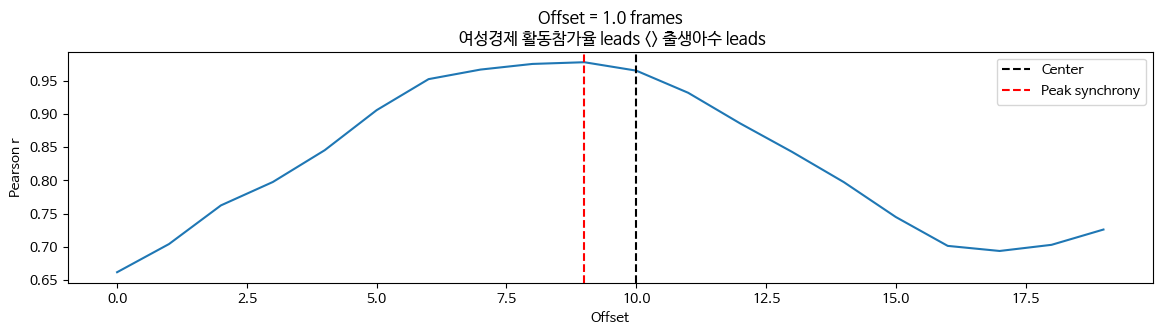

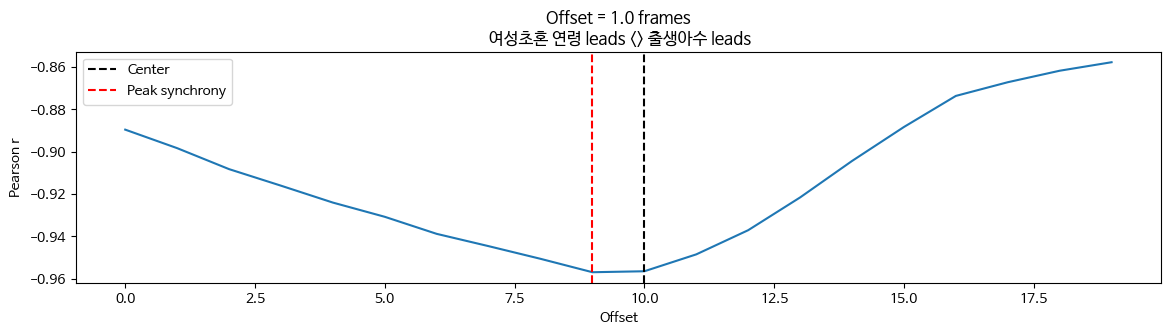

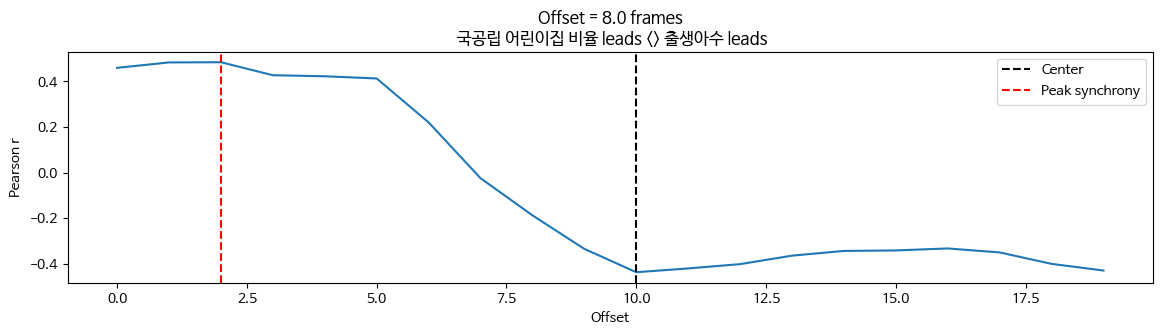

In [17]:
for i in range(len(select_data)):
    lags = 9
    try:
      rs = [crosscorr(select_data[i][select_data[i].columns[0]],y[y.columns[0]], lag) for lag in range(-lags-1,lags+1)]
    except:
      rs = [crosscorr(select_data[i],y[y.columns[0]], lag) for lag in range(-lags-1,lags+1)]
    offset = np.floor(len(rs)/2)-np.argmax(np.abs(rs)) # 최대 correlation 값 가지는 offset 계산 >> 절댓값

    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs)
    ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(np.abs(rs)),color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'Offset = {offset} frames\n {select_name[i]} leads <> 출생아수 leads', xlabel='Offset',ylabel='Pearson r')
    # ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
    # ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
    plt.legend()

# -6 : GNI 증감율이 lag 6 당겨지면 상관관계가 최대화된다.
# 3 : 출생아수가 lag 3 당겨지면 상관관계가 최대화된다.